<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 1 Sprint 3 Assignment 1*

# Apply the t-test to real data

Your assignment is to determine which issues have "statistically significant" differences between political parties in this [1980s congressional voting data](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records). The data consists of 435 instances (one for each congressperson), a class (democrat or republican), and 16 binary attributes (yes or no for voting for or against certain issues). Be aware - there are missing values!

Your goals:

1. Load and clean the data (or determine the best method to drop observations when running tests)
2. Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01
3. Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01
4. Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)

Note that this data will involve *2 sample* t-tests, because you're comparing averages across two groups (republicans and democrats) rather than a single group against a null hypothesis.

Stretch goals:

1. Refactor your code into functions so it's easy to rerun with arbitrary variables
2. Apply hypothesis testing to your personal project data (for the purposes of this notebook you can type a summary of the hypothesis you formed and tested)



In [1]:
import pandas as pd 

In [2]:
col_names = ['Party Affiliation',
'handicapped-infants',
'water-project-cost-sharin',
'adoption-of-the-budget-resolution',
'physician-fee-freeze',
'el-salvador-aid',
'religious-groups-in-schools',
'anti-satellite-test-ban',
'aid-to-nicaraguan-contras',
'mx-missile',
'immigration',
'synfuels-corporation-cutback',
'education-spending',
'superfund-right-to-sue',
'crime',
'duty-free-exports',
'export-administration-act-south-africa']

In [3]:
df = pd.read_csv('/Users/imac/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/module1-statistics-probability-and-inference/house-votes-84.data', header=None)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [5]:
republican = df.loc[df[0] == 'republican']

In [6]:
republican.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
7,republican,n,y,n,y,y,y,n,n,n,n,n,n,y,y,?,y
8,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,y
10,republican,n,y,n,y,y,n,n,n,n,n,?,?,y,y,n,n


In [7]:
len(republican.loc[republican[1] == 'n'])

134

In [8]:
rep_n = []

In [9]:
for i in republican.columns:
    count = len(republican.loc[republican[i] == 'n'])
    rep_n.append(count)
    

In [10]:
rep_n = rep_n[1:17]


In [11]:
rep_n

[134, 73, 142, 2, 8, 17, 123, 133, 146, 73, 138, 20, 22, 3, 142, 50]

In [12]:
rep_y = []

In [13]:
for i in republican.columns:
    count = len(republican.loc[republican[i] == 'y'])
    rep_y.append(count)

In [14]:
rep_y = rep_y[1:17]

In [15]:
rep_y

[31, 75, 22, 163, 157, 149, 39, 24, 19, 92, 21, 135, 136, 158, 14, 96]

In [16]:
rep_q = []

In [17]:
for i in republican.columns:
    count = len(republican.loc[republican[i] == '?'])
    rep_q.append(count)

In [18]:
rep_q = rep_q[1:17]

In [19]:
rep_q

[3, 20, 4, 3, 3, 2, 6, 11, 3, 3, 9, 13, 10, 7, 12, 22]

In [20]:
democrat = df.loc[df[0] == 'democrat']

In [21]:
dem_n = []

In [22]:
for i in democrat.columns:
    count = len(democrat.loc[democrat[i] == 'n'])
    dem_n.append(count)

In [23]:
dem_n = dem_n[1:17]

In [24]:
dem_n

[102, 119, 29, 245, 200, 135, 59, 45, 60, 139, 126, 213, 179, 167, 91, 12]

In [25]:
dem_y = []

In [26]:
for i in democrat.columns:
    count = len(democrat.loc[democrat[i] == 'y'])
    dem_y.append(count)

In [27]:
dem_y = dem_y[1:17]

In [28]:
dem_y

[156, 120, 231, 14, 55, 123, 200, 218, 188, 124, 129, 36, 73, 90, 160, 173]

In [29]:
dem_q =[]

In [30]:
for i in democrat.columns:
    count = len(democrat.loc[democrat[i] == '?'])
    dem_q.append(count)

In [31]:
dem_q = dem_q[1:17]

In [32]:
dem_q

[9, 28, 7, 8, 12, 9, 8, 4, 19, 4, 12, 18, 15, 10, 16, 82]

In [38]:
df = pd.read_csv('/Users/imac/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/module1-statistics-probability-and-inference/vote counts.csv', header=None, names=col_names)

In [34]:
df.index

RangeIndex(start=0, stop=6, step=1)

In [35]:
df.columns

Index(['Party Affiliation', 'handicapped-infants', 'water-project-cost-sharin',
       'adoption-of-the-budget-resolution', 'physician-fee-freeze',
       'el-salvador-aid', 'religious-groups-in-schools',
       'anti-satellite-test-ban', 'aid-to-nicaraguan-contras', 'mx-missile',
       'immigration', 'synfuels-corporation-cutback', 'education-spending',
       'superfund-right-to-sue', 'crime', 'duty-free-exports',
       'export-administration-act-south-africa'],
      dtype='object')

In [36]:
import matplotlib.pyplot as plt
import numpy as np 

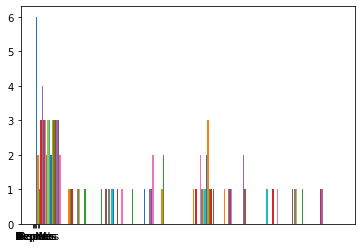

In [41]:
plt.hist(df.T);

In [42]:
import seaborn as sns 

In [159]:
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel

In [160]:
df.head()

,Party Affiliation,handicapped-infants,water-project-cost-sharin,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,-1,1,-1,1,1,1,-1,-1,-1,1,0,1,1,1,-1,1
1,republican,-1,1,-1,1,1,1,-1,-1,-1,-1,-1,1,1,1,-1,0
2,democrat,0,1,1,0,1,1,-1,-1,-1,-1,1,-1,1,1,-1,-1
3,democrat,-1,1,1,-1,0,1,-1,-1,-1,-1,1,-1,1,-1,-1,1
4,democrat,1,1,1,-1,1,1,-1,-1,-1,-1,1,0,1,1,1,1


In [161]:
df = df.replace(['n','y','?'],[-1,1,0] )

In [162]:
df = pd.read_csv('/Users/imac/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/module1-statistics-probability-and-inference/house-votes-84.data', header=None)

In [163]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [164]:
df1 = pd.read_csv('/Users/imac/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/module1-statistics-probability-and-inference/vote counts.csv', header=None, names=col_names)

In [165]:
df1 = df1.T

In [166]:
df1.head()

,0,1,2,3,4,5
Party Affiliation,RepNo,DemNo,RepYes,DemYes,Repabs,Demabs
handicapped-infants,134,102,31,156,3,9
water-project-cost-sharin,73,119,75,120,20,28
adoption-of-the-budget-resolution,142,29,22,231,4,7
physician-fee-freeze,2,245,163,14,3,8


In [170]:
import pandas as pd
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel

In [220]:
df = pd.read_csv('/Users/imac/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/module1-statistics-probability-and-inference/house-votes-84.data', header=None, names=col_names, index_col='Party Affiliation')

In [221]:
df = df.replace(['n','y','?'],[1,2,0] )

In [222]:
df.head()

,handicapped-infants,water-project-cost-sharin,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
Party Affiliation,,,,,,,,,,,,,,,,
republican,1,2,1,2,2,2,1,1,1,2,0,2,2,2,1,2
republican,1,2,1,2,2,2,1,1,1,1,1,2,2,2,1,0
democrat,0,2,2,0,2,2,1,1,1,1,2,1,2,2,1,1
democrat,1,2,2,1,0,2,1,1,1,1,2,1,2,1,1,2
democrat,2,2,2,1,2,2,1,1,1,1,2,0,2,2,2,2


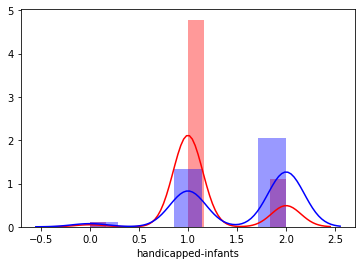

In [223]:
sns.distplot(df[df.index == 'republican']['handicapped-infants'],color='red')
sns.distplot(df[df.index == 'democrat']['handicapped-infants'],color='blue');

In [224]:
stat, pvalue = ttest_ind(df[df.index == 'republican']['handicapped-infants'], df[df.index == 'democrat']['handicapped-infants'])
print(stat, pvalue)

-7.617531058693107 1.6420491818260538e-13


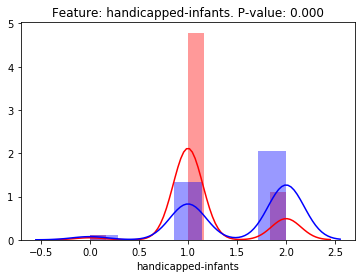

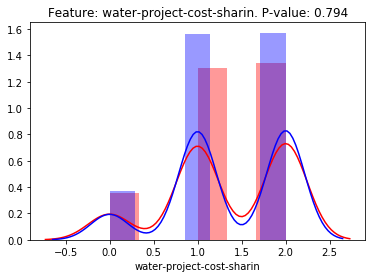

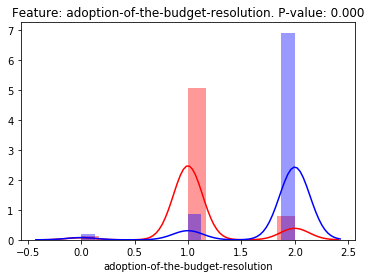

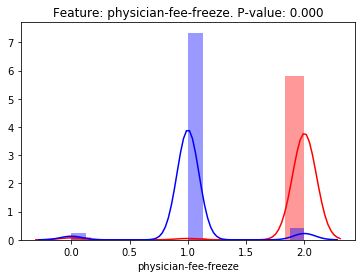

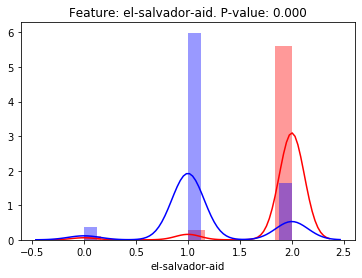

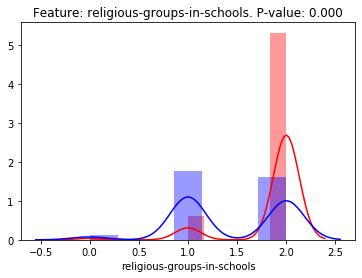

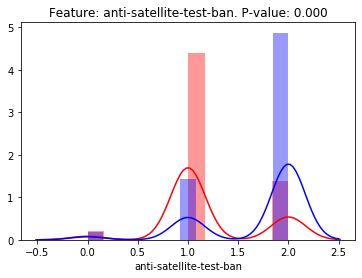

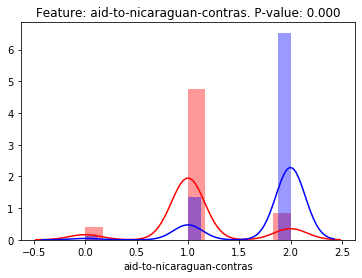

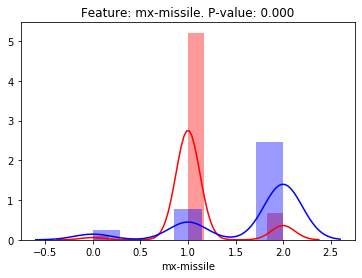

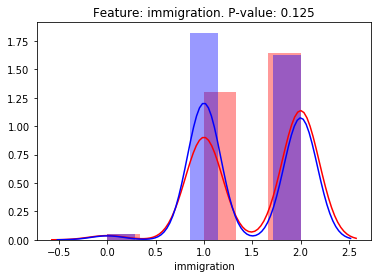

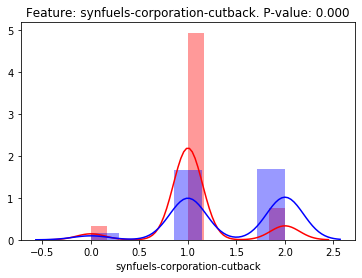

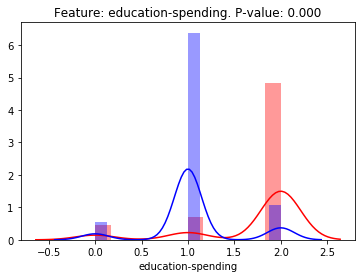

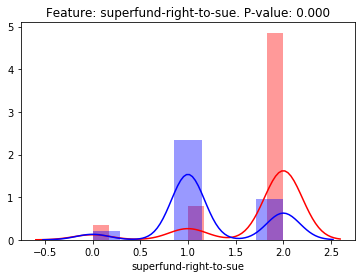

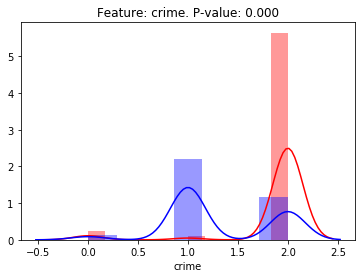

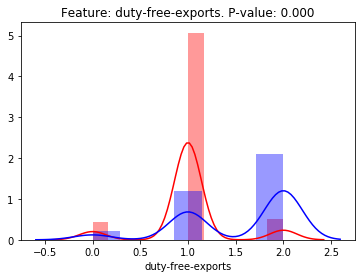

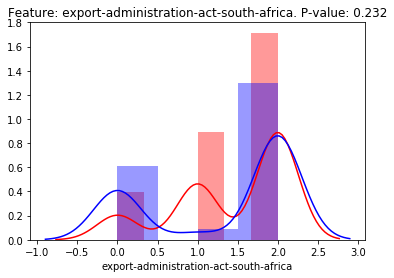

<Figure size 432x288 with 0 Axes>

In [228]:
for feat in df.columns:
  group1 = df[df.index == 'republican'][feat]
  group2 = df[df.index == 'democrat'][feat]
  sns.distplot(group1, color='red')
  sns.distplot(group2, color='blue')
  _, pvalue = ttest_ind(group1, group2)
  plt.title(f'Feature: {feat}. P-value: {pvalue:.3f}')
  plt.figure()